# Import Data

In [1]:
import json
import requests

In [2]:
def run_query(query): # A simple function to use requests to make the API call. Returns json content from query.
    request = requests.get('https://my.es.net/graphql', json={'query': query})
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

In [3]:
def query_edge(edge_id, beginTime, endTime):
    query = '''
    {
      mapTopologyEdge(id: "%s") {
            name
        traffic(beginTime: "%s", endTime: "%s")
      }
    }
    ''' % (edge_id, beginTime, endTime)
    
    return  run_query(query)

In [4]:
edge_1767 = query_edge("1767", "2018-05-17T18:22:53.253Z", "2018-05-21T19:22:53.253Z")

# Clean Data

In [5]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
%matplotlib inline

In [6]:
#Clean data for single edge

def clean_edge_data(json_data):
    #get "traffic" label from json data
    traffic = str(json_data['data']['mapTopologyEdge']['traffic'])

    #get index of "points" label
    index = traffic.find("points")

    #get "points" data
    in_out = traffic[index+len("points: "):].split("],")
    points = [str(item).strip().replace("[", "").replace("]", "").replace(",", "").split() for item in in_out]
    points = points[0:len(points)-1]

    #get labels of points data (ex. CHIC--STAR, STAR--CHIC)
    labels = traffic[traffic.find("labels")+len("labels: "):].split("],")[0].replace("[", 
                                            "").replace("]", "").replace(",", "").replace('"', "").strip().split()
    #Add "Time" to list for header in DataFrame
    labels = ["Time"] + labels
    
    #Create DataFrame
    df = pd.DataFrame(points, columns=labels)
    df = df.astype('float')
    df['Time'] = df['Time'].apply(lambda x: datetime.fromtimestamp(x/1000.))
    
    return df

In [7]:
#Create DataFrame
points_1767 = clean_edge_data(edge_1767)
points_1767.head()

,Time,CHIC--STAR,STAR--CHIC
0,2018-05-17 18:22:30,1.859851e+10,3.569843e+10
1,2018-05-17 18:23:00,1.535689e+10,3.426093e+10
2,2018-05-17 18:23:30,1.760799e+10,3.044021e+10
3,2018-05-17 18:24:00,1.722827e+10,3.022598e+10
4,2018-05-17 18:24:30,1.822713e+10,3.231589e+10


# Feature Extraction

In [8]:
def edge_features(df, pathway):
    #Get only one pathway (CHIC--STAR)
    single_pathway = df[['Time', pathway]]

    #Convert times to datetime objects
    times = single_pathway['Time']

    #Is date weekend?
    weekends = times.apply(lambda x: x.weekday() >= 5)*1
    single_pathway['Weekend'] = weekends

    #Add day of the week
    days = times.apply(lambda x: x.weekday())
    single_pathway['Day'] = days

    #Add hours, minutes
    hours = times.apply(lambda x: x.hour)
    minutes = times.apply(lambda x: x.minute + x.second/60.)
    single_pathway['Hour'] = hours
    single_pathway['Minute'] = minutes

    return single_pathway

In [9]:
points_1767_chicstar = edge_features(points_1767, 'CHIC--STAR')
points_1767_chicstar.head()

,Time,CHIC--STAR,Weekend,Day,Hour,Minute
0,2018-05-17 18:22:30,1.859851e+10,0,3,18,22.5
1,2018-05-17 18:23:00,1.535689e+10,0,3,18,23.0
2,2018-05-17 18:23:30,1.760799e+10,0,3,18,23.5
3,2018-05-17 18:24:00,1.722827e+10,0,3,18,24.0
4,2018-05-17 18:24:30,1.822713e+10,0,3,18,24.5


# Model

In [10]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, model_from_json, Model
from keras.layers import Dense, LSTM, Activation, Dropout, Bidirectional, TimeDistributed, RepeatVector, Input, GRU
#from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD
#from keras.utils import multi_gpu_model
from random import uniform
import json
# Fix AttributeError: 'module' object has no attribute 'control_flow_ops'
import tensorflow
from tensorflow.python.ops import control_flow_ops
tensorflow.control_flow_ops = control_flow_ops

Using TensorFlow backend.


In [11]:
def inverse_transform(pred, traffic_scaler):    
    return traffic_scaler.inverse_transform(pred)

## Reversed Target Sequences

In [12]:
def train_test_multistep_reversesource(df, pathway, split_proportion, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):
    #Split features from response variable
    X = df[[pathway]].as_matrix()
    X = scaler.fit_transform(X)
    
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    #Train-test split
    row = int(round(split_proportion * df.shape[0]))
    
    for index in range(row):
        X_train.append(np.flip(X[index: index + seq_len_x], axis = 0)) #reverse source sequence
        Y_train.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])
    
    for index in range(row + seq_len_x, X.shape[0] - (seq_len_x + seq_len_y + 1)):
        X_test.append(np.flip(X[index: index + seq_len_x], axis = 0)) #reverse source sequence
        Y_test.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])

    X_train = np.array(X_train)
    X_train = X_train.reshape(X_train.shape[0], X_train[0].shape[0])
    Y_train = np.array(Y_train)
    Y_train = Y_train.reshape(Y_train.shape[0], Y_train[0].shape[0])
    
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0], X_test[0].shape[0])
    Y_test = np.array(Y_test)
    Y_test = Y_test.reshape(Y_test.shape[0], Y_test[0].shape[0])

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 1))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [13]:
def train_test_multistepnew(df, pathway, split_proportion, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):
    #Split features from response variable
    X = df[[pathway]].as_matrix()
    X = scaler.fit_transform(X)
    
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    #Train-test split
    row = int(round(split_proportion * df.shape[0]))
    
    for index in range(row):
        X_train.append(X[index: index + seq_len_x]) #adding CHIC--STAR
        Y_train.append(np.flip(X[index: index + seq_len_x], axis = 0)) #revese target
    
    for index in range(row + seq_len_x, X.shape[0] - (seq_len_x + seq_len_y + 1)):
        X_test.append(X[index: index + seq_len_x]) #adding CHIC--STAR
        Y_test.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])

    X_train = np.array(X_train)
    X_train = X_train.reshape(X_train.shape[0], X_train[0].shape[0])
    Y_train = np.array(Y_train)
    Y_train = Y_train.reshape(Y_train.shape[0], Y_train[0].shape[0])
    
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0], X_test[0].shape[0])
    Y_test = np.array(Y_test)
    Y_test = Y_test.reshape(Y_test.shape[0], Y_test[0].shape[0])

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 1))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X_train, Y_train, X_test, Y_test = train_test_multistepnew(points_1767_chicstar, 
                                                            "CHIC--STAR", 0.87, 20, 20, scaler, traffic_scaler)

X_train shape:  (10128, 20, 1)
Y_train shape:  (10128, 20, 1)
X_test shape:  (1452, 20, 1)
Y_test shape:  (1452, 20, 1)


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [15]:
batch_size = 24
nb_epoch = 150

model_multiple_reversed = Sequential()
model_multiple_reversed.add(LSTM(input_dim = 1, output_dim=150, return_sequences=False))
model_multiple_reversed.add(RepeatVector(20)) #seq_len_y
model_multiple_reversed.add(LSTM(output_dim=150, return_sequences=True))
model_multiple_reversed.add(LSTM(output_dim=150, return_sequences=True))
model_multiple_reversed.add(TimeDistributed(Dense(1))) 

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, return_sequences=False, input_shape=(None, 1))`
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, return_sequences=True)`
  import sys
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, return_sequences=True)`
  


In [16]:
model_multiple_reversed.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 150)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 150)           180600    
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 150)           180600    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 1)             151       
Total params: 452,551
Trainable params: 452,551
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("-- Building --")
model_multiple_reversed.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model_multiple_reversed.fit(X_train, Y_train, epochs=1, batch_size=batch_size, validation_split = 0.2, shuffle=False)
    model_multiple_reversed.reset_states()

In [50]:
from keras.models import load_model

model_multiple_reversed.save('model_multiple_reversed.h5')

In [16]:
# returns a compiled model
# identical to the previous one
model_multiple_reversed.compile(loss="mse",
                  optimizer = 'adam')
model_multiple_reversed.load_weights('model_multiple_reversed.h5')

In [20]:
# walk-forward validation on the test data
pred_x_test = model_multiple_reversed.predict(X_test, batch_size)
pred_x_test = np.reshape(pred_x_test, (pred_x_test.shape[0], pred_x_test.shape[1]))
pred_test = inverse_transform(pred_x_test, scaler)

y_test = np.float_(Y_test)
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))
y_test_inv = inverse_transform(y_test, scaler)

In [39]:
model_multiple_reversed.evaluate(X_test, Y_test)

1408/1452 [============================>.] - ETA: 0s

0.003761668087909455

In [19]:
predictions = []
pred = model_multiple_reversed.predict(X_train[-1:].reshape(1,20,1))
for i in range(100,200):
    #pred = model_multiple_reversed.predict(X_test[i].reshape(1,20,1))
    arr = np.array(np.vstack((X_test[i][1:], [pred[0][0]]))).reshape(1,20,1)
    pred = model_multiple_reversed.predict(arr)
    predictions_i = []
    for j in range(39):
        pred = model_multiple_reversed.predict(arr)
        if j%2 == 1:
            predictions_i.append(pred[0][j/2])
        arr = np.array(np.vstack((arr[0][1:], [pred[0][0]]))).reshape(1,20,1)
    predictions.append(predictions_i)
print(len(predictions[0]))

19


In [48]:
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
for i in range(10):
    print("Predicted: ")
    print(pred_test[i])
    print("Truth: ")
    print(y_test_inv[i])

Predicted: 
[  1.50100224e+10   1.62598431e+10   1.41640458e+10   1.15763323e+10
   1.09723484e+10   1.09381386e+10   1.27382129e+10   1.62230077e+10
   1.79791114e+10   1.58773340e+10   1.40043213e+10   1.29977866e+10
   1.27634278e+10   1.32959775e+10   1.40049981e+10   1.48436552e+10
   1.36855818e+10   1.03105167e+10   9.17057946e+09   1.07888282e+10]
Truth: 
[  1.25347381e+10   1.44632459e+10   1.01727248e+10   1.11022175e+10
   1.71064673e+10   1.05983874e+10   1.01357537e+10   1.17073898e+10
   1.83513207e+10   1.46923985e+10   8.91312740e+09   1.18954619e+10
   1.29459639e+10   1.01956134e+10   8.58626287e+09   8.20472182e+09
   1.33442834e+10   1.37512731e+10   1.18798351e+10   9.78449776e+09]
Predicted: 
[  1.25230121e+10   1.49387796e+10   1.64134636e+10   1.40801556e+10
   1.17714125e+10   1.07606036e+10   1.08707246e+10   1.28013988e+10
   1.62205491e+10   1.80116173e+10   1.60554527e+10   1.39336632e+10
   1.29964483e+10   1.30446909e+10   1.32234772e+10   1.37380516e+10


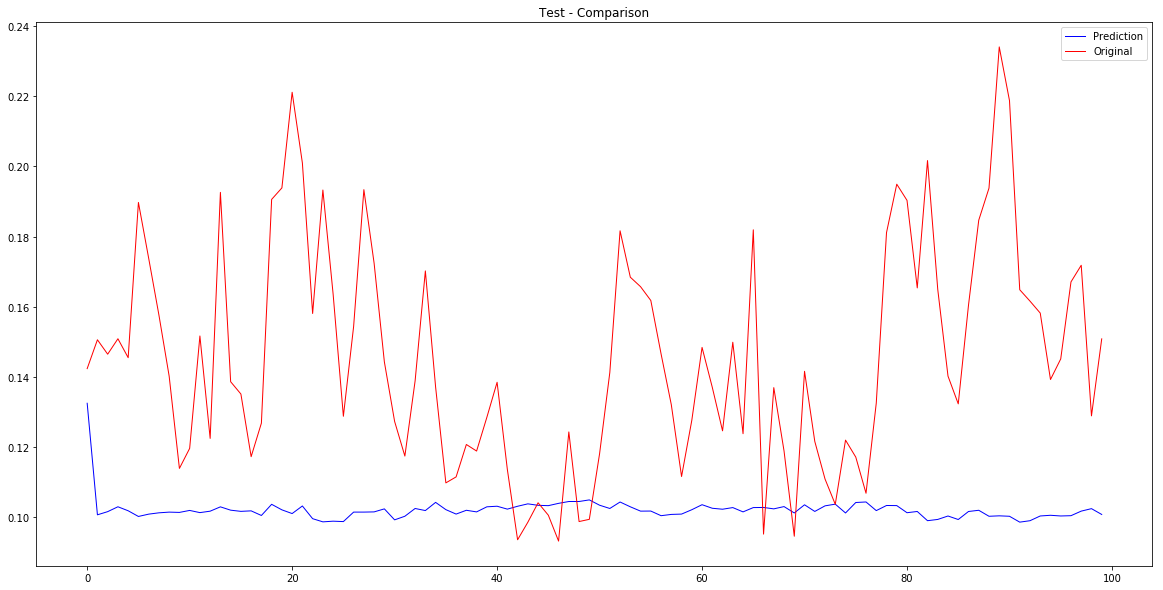

In [20]:
#1 timestep ahead has good prediction

y_test = np.float_(Y_test)
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))

pred_first = [item[0] for item in predictions][:]
y_first = [item[0] for item in y_test][100:200]

# line_test_pred = np.reshape(pred_test, pred_test.shape[0])
# line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
plt.figure(figsize=(20,10))
plt.plot(pred_first, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison')
plt.show()

## Online Learning

In [ ]:
newpoint = X_
model_multiple_reversed.fit

## Stateful

In [14]:
def train_test_multistep_stateful(df, pathway, split_proportion, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):
    #Split features from response variable
    X = df[[pathway]].as_matrix()
    X = scaler.fit_transform(X)
    
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    #Train-test split
    row = int(round(split_proportion * df.shape[0]))
    
    for index in range(0, row, seq_len_x+seq_len_y):
        X_train.append(X[index: index + seq_len_x]) #reverse source sequence
        Y_train.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])
    
    for index in range(row + seq_len_x, X.shape[0] - (seq_len_x + seq_len_y + 1)):
        X_test.append(np.flip(X[index: index + seq_len_x], axis = 0)) #reverse source sequence
        Y_test.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])

    X_train = np.array(X_train)
    X_train = X_train.reshape(X_train.shape[0], X_train[0].shape[0])
    Y_train = np.array(Y_train)
    Y_train = Y_train.reshape(Y_train.shape[0], Y_train[0].shape[0])
    
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0], X_test[0].shape[0])
    Y_test = np.array(Y_test)
    Y_test = Y_test.reshape(Y_test.shape[0], Y_test[0].shape[0])

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 1))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [20]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X_train, Y_train, X_test, Y_test = train_test_multistep_stateful(points_1767_chicstar, 
                                                            "CHIC--STAR", 0.9, 20, 20, scaler, traffic_scaler)

X_train shape:  (1299, 20, 1)
Y_train shape:  (1299, 20, 1)
X_test shape:  (5711, 20, 1)
Y_test shape:  (5711, 20, 1)


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [23]:
batch_size = 1
nb_epoch = 500

model_multiple_stateful = Sequential()
model_multiple_stateful.add(LSTM(batch_input_shape = (batch_size, 20, 1), output_dim=128, return_sequences=False, 
                                 stateful = True))
model_multiple_stateful.add(RepeatVector(20)) #seq_len_y
model_multiple_stateful.add(LSTM(output_dim=128, return_sequences=True, stateful = True))
model_multiple_stateful.add(TimeDistributed(Dense(1)))

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(stateful=True, return_sequences=False, units=128, batch_input_shape=(1, 20, 1))`
  
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(stateful=True, return_sequences=True, units=128)`
  


In [24]:
print("-- Building --")
model_multiple_stateful.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model_multiple_stateful.fit(X_train, Y_train, epochs=1, batch_size=batch_size, 
                                #validation_data = (X_test, Y_test), 
                                shuffle=False)
    model_multiple_stateful.reset_states()

-- Building --
-- Training --
Epoch 1/1
1299/1299 [==============================] - 61s - loss: 0.0059    
Epoch 1/1
1299/1299 [==============================] - 62s - loss: 0.0056    
Epoch 1/1
1299/1299 [==============================] - 63s - loss: 0.0055    
Epoch 1/1
1299/1299 [==============================] - 62s - loss: 0.0054    
Epoch 1/1
1299/1299 [==============================] - 62s - loss: 0.0054    
Epoch 1/1
1299/1299 [==============================] - 61s - loss: 0.0055    
Epoch 1/1
1299/1299 [==============================] - 61s - loss: 0.0055    
Epoch 1/1
1299/1299 [==============================] - 61s - loss: 0.0056    
Epoch 1/1
1299/1299 [==============================] - 61s - loss: 0.0055    
Epoch 1/1
1299/1299 [==============================] - 58s - loss: 0.0055    
Epoch 1/1
1299/1299 [==============================] - 60s - loss: 0.0055    
Epoch 1/1
1299/1299 [==============================] - 61s - loss: 0.0055    
Epoch 1/1
1299/1299 [=============

1299/1299 [==============================] - 60s - loss: 0.0024    
Epoch 1/1
1299/1299 [==============================] - 60s - loss: 0.0029    
Epoch 1/1
1299/1299 [==============================] - 59s - loss: 0.0033    
Epoch 1/1
 200/1299 [===>..........................] - ETA: 50s - loss: 0.0020

KeyboardInterrupt: 

In [19]:
# walk-forward validation on the test data
pred_x_test = model_multiple_stateful.predict(X_test, batch_size)
pred_x_test = np.reshape(pred_x_test, (pred_x_test.shape[0], pred_x_test.shape[2]))
pred_test = inverse_transform(pred_x_test, scaler)

y_test = np.float_(Y_test)
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[2]))
y_test_inv = inverse_transform(y_test, scaler)

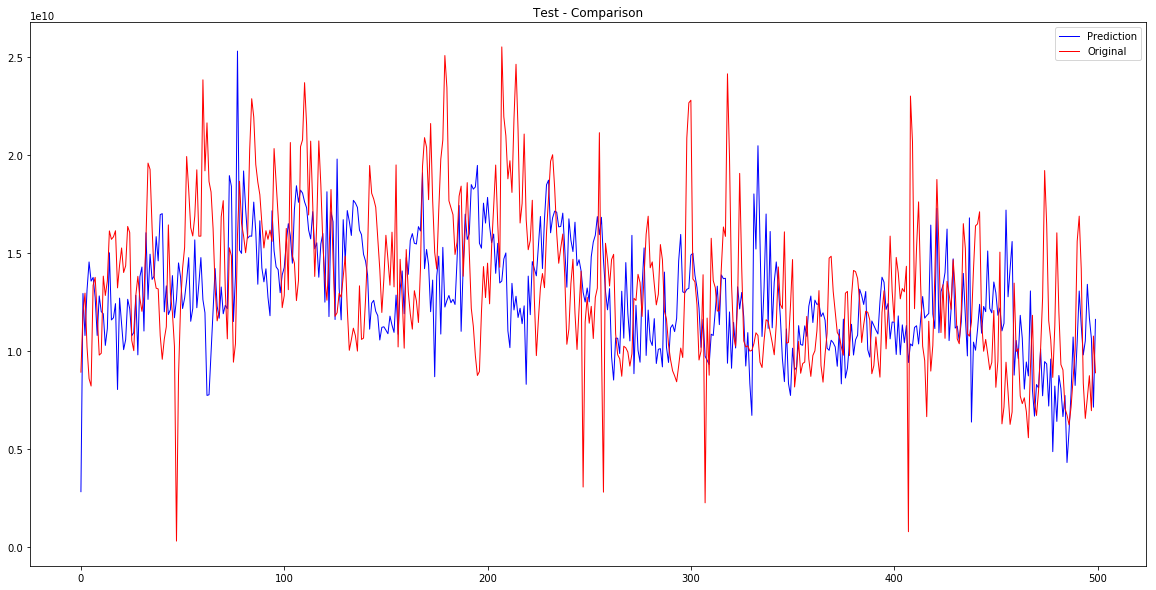

In [23]:
#1 timestep ahead has good prediction

pred_first = [item[10] for item in pred_test][0:500]
y_first = [item[10] for item in y_test_inv][0:500]

# line_test_pred = np.reshape(pred_test, pred_test.shape[0])
# line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
plt.figure(figsize=(20,10))
plt.plot(pred_first, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison')
plt.show()

## Whole sequence input

In [69]:
def train_test_multistep_wholesequence(df, pathway, split_proportion, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):
    #Split features from response variable
    X = df[[pathway]].as_matrix()
    X = scaler.fit_transform(X)
    
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    #Train-test split

    X_train.append(X[0: seq_len_x])
    Y_train.append(X[1: seq_len_x + 1])
    
    for index in range(seq_len_x + 1, X.shape[0] - (seq_len_x + seq_len_y + 1)):
        X_test.append(X[index: index + seq_len_x]) 
        Y_test.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])

    X_train = np.array(X_train)
    X_train = X_train.reshape(X_train[0].shape[0], 1, 1)
    Y_train = np.array(Y_train)
    Y_train = Y_train.reshape(Y_train[0].shape[0])
    
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0], X_test[0].shape[0])
    Y_test = np.array(Y_test)
    Y_test = Y_test.reshape(Y_test.shape[0], Y_test[0].shape[0])

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    #Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 1))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [70]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X_train, Y_train, X_test, Y_test = train_test_multistep_wholesequence(points_1767_chicstar, 
                                                            "CHIC--STAR", 0.87, 5000, 20, scaler, traffic_scaler)

X_train shape:  (1, 5000, 1)
Y_train shape:  (1, 5000)
X_test shape:  (1619, 5000, 1)
Y_test shape:  (1619, 20, 1)


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [65]:
batch_size = 200
nb_epoch = 500

model_multiple_reversed_wholesequence = Sequential()
model_multiple_reversed_wholesequence.add(LSTM(128, input_shape=(None, 20), return_sequences=True))
model_multiple_reversed_wholesequence.add(Dense(1)) 

In [109]:
print("-- Building --")
model_multiple_reversed_wholesequence.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
model_multiple_reversed_wholesequence.fit(X_train, Y_train, epochs=nb_epoch, batch_size = batch_size, shuffle=False)

-- Building --
-- Training --


ValueError: Error when checking input: expected lstm_27_input to have shape (None, None, 20) but got array with shape (5000, 1, 1)

In [89]:
newModel = Sequential()
newModel.add(LSTM(128, batch_input_shape=(1, None,1), return_sequences=False, stateful=True))
newModel.add(Dense(1)) 

In [90]:
newModel.set_weights(model_multiple_reversed_wholesequence.get_weights())

In [91]:
X = X_test[0].reshape(1,200,1) #input
prediction = newModel.predict(X).reshape(1,1,1)
prediction_list = [prediction]
for i in range(19):
    prediction = newModel.predict(prediction).reshape(1,1,1)
    prediction_list.append(prediction)
prediction_list

[array([[[ 0.45757297]]], dtype=float32),
 array([[[ 0.62467062]]], dtype=float32),
 array([[[ 0.8340466]]], dtype=float32),
 array([[[ 1.10382652]]], dtype=float32),
 array([[[ 1.45369673]]], dtype=float32),
 array([[[ 1.90536809]]], dtype=float32),
 array([[[ 2.48000431]]], dtype=float32),
 array([[[ 3.19662952]]], dtype=float32),
 array([[[ 4.04389429]]], dtype=float32),
 array([[[ 5.01072645]]], dtype=float32),
 array([[[ 6.04197168]]], dtype=float32),
 array([[[ 7.0671401]]], dtype=float32),
 array([[[ 8.00620079]]], dtype=float32),
 array([[[ 8.79856396]]], dtype=float32),
 array([[[ 9.41809464]]], dtype=float32),
 array([[[ 9.86127281]]], dtype=float32),
 array([[[ 10.14996624]]], dtype=float32),
 array([[[ 10.3237257]]], dtype=float32),
 array([[[ 10.42430687]]], dtype=float32),
 array([[[ 10.48189831]]], dtype=float32)]

## Trying timesteps as features

In [110]:
def train_test_multistep(df, pathway, split_proportion, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):
    
    #Split features from response variable
    X = df[[pathway]].as_matrix()
    
    result_X = []
    result_Y = []

    for index in range(X.shape[0] - (seq_len_x + seq_len_y + 1)):
        result_X.append(X[index: index + seq_len_x]) #adding CHIC--STAR
        result_Y.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])

    result_X = np.array(result_X)
    result_X = result_X.reshape(result_X.shape[0], result_X[0].shape[0])
    result_Y = np.array(result_Y)
    result_Y = result_Y.reshape(result_Y.shape[0], result_Y[0].shape[0])

    #Normalize
    result_X = scaler.fit_transform(result_X)
    result_Y = traffic_scaler.fit_transform(result_Y)

    #Train-test split
    row = int(round(split_proportion * df.shape[0]))
    X_train = result_X[:row]
    Y_train = result_Y[:row]
    X_test = result_X[row:]
    Y_test = result_Y[row:]

    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    Y_train = np.reshape(Y_train, (Y_train.shape[0], 1, Y_train.shape[1]))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], 1, Y_test.shape[1]))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [111]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X_train, Y_train, X_test, Y_test = train_test_multistep(points_1767_chicstar, 
                                                            "CHIC--STAR", 0.87, 40, 20, scaler, traffic_scaler)

X_train shape:  (10128, 1, 40)
Y_train shape:  (10128, 1, 20)
X_test shape:  (1452, 1, 40)
Y_test shape:  (1452, 1, 20)


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [112]:
batch_size = 24
nb_epoch = 3000

model_multiple_10min = Sequential()
model_multiple_10min.add(LSTM(input_dim = 40, output_dim=128, return_sequences=True))
model_multiple_10min.add(LSTM(output_dim=128, return_sequences=True))
model_multiple_10min.add(Dense(20)) 

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=128, return_sequences=True, input_shape=(None, 40))`
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=128, return_sequences=True)`
  


In [113]:
print("-- Building --")
model_multiple_10min.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model_multiple_10min.fit(X_train, Y_train, epochs=1, batch_size=batch_size, shuffle=False)
    model_multiple_10min.reset_states()

-- Building --
-- Training --
Epoch 1/1
10128/10128 [==============================] - 5s - loss: 0.0055     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0045     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0045     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0045     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0046     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0046     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0046     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0046     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0046     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0045     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0045     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0045     
Epoch 1/1


10128/10128 [==============================] - 4s - loss: 0.0037     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0037     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0037     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0037     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0037     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0037     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0037     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0037     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0037     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0037     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0037     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0036     
Epoch 1/1
10128/10128 [===========================

10128/10128 [==============================] - 4s - loss: 0.0027     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0027     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0027     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0027     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0027     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0027     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0027     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0027     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0027     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0027     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0027     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0027     
Epoch 1/1
10128/10128 [===========================

10128/10128 [==============================] - 4s - loss: 0.0019     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0019     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0019     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0019     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0020     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0020     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0020     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0020     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0020     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0020     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0020     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0020     
Epoch 1/1
10128/10128 [===========================

10128/10128 [==============================] - 4s - loss: 0.0017     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0016     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0016     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0016     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0016     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0017     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0016     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0016     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0016     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0016     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0016     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0016     
Epoch 1/1
10128/10128 [===========================

10128/10128 [==============================] - 4s - loss: 0.0014     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0015     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0015     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0014     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0014     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0014     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0014     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0014     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0014     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0014     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0014     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0014     
Epoch 1/1
10128/10128 [===========================

10128/10128 [==============================] - 4s - loss: 0.0013     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0013     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0013     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0013     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0013     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0013     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0013     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0013     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0013     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0013     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0013     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0013     
Epoch 1/1
10128/10128 [===========================

10128/10128 [==============================] - 4s - loss: 0.0012     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0012     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0012     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0012     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0012     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0013     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0012     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0012     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0012     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0012     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0012     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0012     
Epoch 1/1
10128/10128 [===========================

10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0012     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [===========================

10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0010     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0010     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0010     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0011     
Epoch 1/1
10128/10128 [===========================

10128/10128 [==============================] - 4s - loss: 9.9626e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.9483e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.9404e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0010     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0010     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0010     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0010     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0010     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0010     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.9106e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0010     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 0.0010     
Epoch 1/1
10128/10128 [===========

10128/10128 [==============================] - 4s - loss: 9.5112e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.7098e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.6574e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.6626e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.8223e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.6625e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.6369e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.5945e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.6088e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.8044e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.6826e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.5102e-04     
Ep

10128/10128 [==============================] - 4s - loss: 9.2982e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.4254e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.4543e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.3058e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.3135e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.2634e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.2966e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.4430e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.6980e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.4707e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.3054e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.1433e-04     
Ep

10128/10128 [==============================] - 4s - loss: 9.0346e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.1878e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.1008e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.9843e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.0089e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.9900e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.0171e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.1791e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.1559e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.1133e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.2045e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.0363e-04     
Ep

10128/10128 [==============================] - 4s - loss: 8.7651e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.6999e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.7760e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.0412e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 9.0819e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.9349e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.9230e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.6815e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.6331e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.6576e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.6974e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.7412e-04     
Ep

10128/10128 [==============================] - 4s - loss: 8.5117e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.5732e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.5420e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.4925e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.4438e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.5383e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.4951e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.5450e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.5394e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.4752e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.4047e-04     
Epoch 1/1
10128/10128 [==============================] - 4s - loss: 8.5471e-04     
Ep

In [121]:
# walk-forward validation on the test data
pred_x_test = model_multiple_10min.predict(X_test, batch_size)
print(pred_x_test.shape)
pred_x_test = np.reshape(pred_x_test, (pred_x_test.shape[0], pred_x_test.shape[2], 1))
pred_x_test = np.reshape(pred_x_test, (pred_x_test.shape[0], pred_x_test.shape[1]))
#pred_test = inverse_transform(pred_x_test, scaler)

y_test = np.float_(Y_test)
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[2]))
#y_test_inv = inverse_transform(y_test, scaler)

(1452, 1, 20)


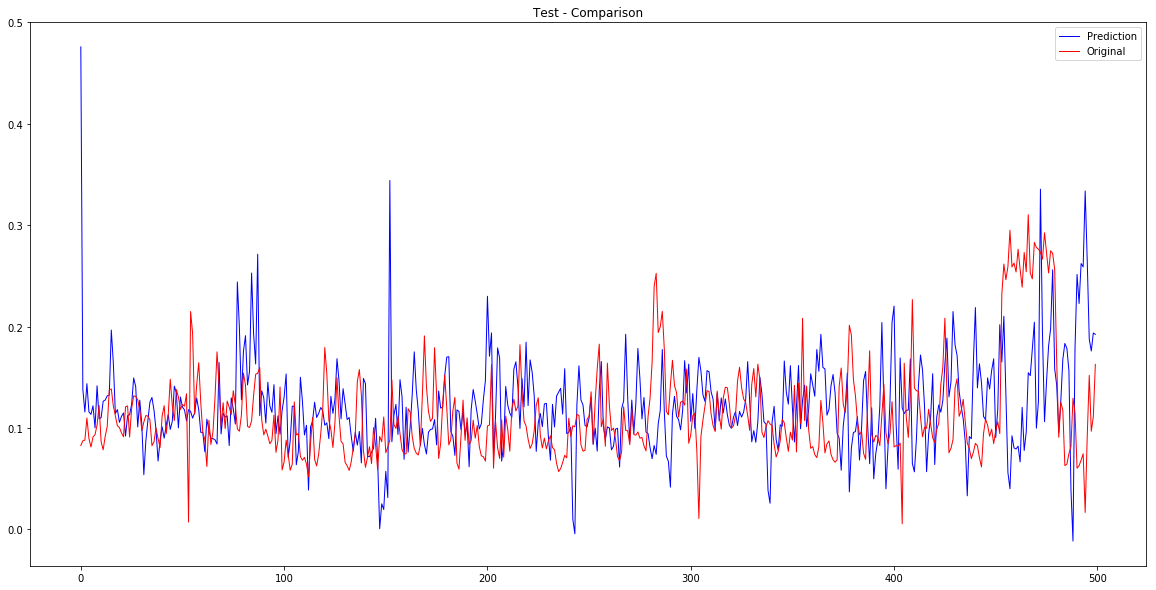

In [131]:
#1 timestep ahead has good prediction

pred_first = [item[14] for item in pred_x_test][350:850]
y_first = [item[14] for item in y_test][350:850]

# line_test_pred = np.reshape(pred_test, pred_test.shape[0])
# line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
plt.figure(figsize=(20,10))
plt.plot(pred_first, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison')
plt.show()

## Additional Dense Layer

In [12]:
def train_test_multistep(df, pathway, split_proportion, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):
    
    #Split features from response variable
    X = df[[pathway]].as_matrix()
    X = scaler.fit_transform(X)
    
    result_X = []
    result_Y = []

    for index in range(X.shape[0] - (seq_len_x + seq_len_y + 1)):
        result_X.append(X[index: index + seq_len_x]) #adding CHIC--STAR
        result_Y.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])

    result_X = np.array(result_X)
    result_X = result_X.reshape(result_X.shape[0], result_X[0].shape[0])
    result_Y = np.array(result_Y)
    result_Y = result_Y.reshape(result_Y.shape[0], result_Y[0].shape[0])

    #Normalize
    result_X = scaler.fit_transform(result_X)
    result_Y = traffic_scaler.fit_transform(result_Y)

    #Train-test split
    row = int(round(split_proportion * df.shape[0]))
    X_train = result_X[:row]
    Y_train = result_Y[:row]
    X_test = result_X[row:]
    Y_test = result_Y[row:]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 1))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X_train, Y_train, X_test, Y_test = train_test_multistep(points_1767_chicstar, 
                                                            "CHIC--STAR", 0.87, 40, 20, scaler, traffic_scaler)

X_train shape:  (10128, 40, 1)
Y_train shape:  (10128, 20, 1)
X_test shape:  (1452, 40, 1)
Y_test shape:  (1452, 20, 1)


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [ ]:
batch_size = 12
nb_epoch = 500

model_addDense = Sequential()
model_addDense.add(LSTM(input_dim = 1, output_dim=128, return_sequences=False))
model_addDense.add(Dropout(0.2))
model_addDense.add(Dense(1)) 
model_addDense.add(RepeatVector(20)) #seq_len_y
model_addDense.add(Activation('linear'))

In [29]:
batch_size = 12
nb_epoch = 500

model_addDense = Sequential()
model_addDense.add(LSTM(input_dim = 1, output_dim=128, return_sequences=False))
model_addDense.add(Dropout(0.2))
model_addDense.add(Dense(1)) 
model_addDense.add(Activation('linear'))
model_addDense.add(RepeatVector(20)) #seq_len_y
model_addDense.add(Activation('linear'))

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=128, return_sequences=False, input_shape=(None, 1))`
  """


In [27]:
batch_size = 12
nb_epoch = 500

model_addDense = Sequential()
model_addDense.add(LSTM(input_dim = 1, output_dim=128, return_sequences=False))
model_addDense.add(Dropout(0.2))
model_addDense.add(Dense(1)) 
model_addDense.add(RepeatVector(20)) #seq_len_y
model_addDense.add(Activation('linear'))
model_addDense.add(TimeDistributed(Dense(1)))

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=128, return_sequences=False, input_shape=(None, 1))`
  """


In [ ]:
print("-- Building --")
model_addDense.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
model_addDense.fit(X_train, Y_train, 
                   epochs=nb_epoch, 
                   batch_size=batch_size, 
                   validation_data = (X_test, Y_test),
                   shuffle=False)

-- Building --
-- Training --
Train on 10128 samples, validate on 1452 samples
Epoch 1/500
10128/10128 [==============================] - 49s - loss: 0.0049 - val_loss: 0.0027
Epoch 2/500
10128/10128 [==============================] - 49s - loss: 0.0048 - val_loss: 0.0028
Epoch 3/500
10128/10128 [==============================] - 49s - loss: 0.0048 - val_loss: 0.0029
Epoch 4/500
10128/10128 [==============================] - 49s - loss: 0.0048 - val_loss: 0.0028
Epoch 5/500
10128/10128 [==============================] - 49s - loss: 0.0048 - val_loss: 0.0028
Epoch 6/500
10128/10128 [==============================] - 50s - loss: 0.0047 - val_loss: 0.0027
Epoch 7/500
10128/10128 [==============================] - 48s - loss: 0.0047 - val_loss: 0.0027
Epoch 8/500
10128/10128 [==============================] - 49s - loss: 0.0046 - val_loss: 0.0026
Epoch 9/500
10128/10128 [==============================] - 48s - loss: 0.0046 - val_loss: 0.0026
Epoch 10/500
10128/10128 [======================

10128/10128 [==============================] - 48s - loss: 0.0035 - val_loss: 0.0025
Epoch 167/500
10128/10128 [==============================] - 48s - loss: 0.0035 - val_loss: 0.0025
Epoch 168/500
10128/10128 [==============================] - 48s - loss: 0.0035 - val_loss: 0.0025
Epoch 169/500
10128/10128 [==============================] - 48s - loss: 0.0035 - val_loss: 0.0025
Epoch 170/500
10128/10128 [==============================] - 48s - loss: 0.0035 - val_loss: 0.0025
Epoch 171/500
10128/10128 [==============================] - 48s - loss: 0.0035 - val_loss: 0.0025
Epoch 172/500
10128/10128 [==============================] - 49s - loss: 0.0035 - val_loss: 0.0025
Epoch 173/500
10128/10128 [==============================] - 49s - loss: 0.0035 - val_loss: 0.0025
Epoch 174/500
10128/10128 [==============================] - 48s - loss: 0.0035 - val_loss: 0.0025
Epoch 175/500
10128/10128 [==============================] - 49s - loss: 0.0035 - val_loss: 0.0025
Epoch 176/500
10128/1012

10128/10128 [==============================] - 48s - loss: 0.0032 - val_loss: 0.0025
Epoch 331/500
10128/10128 [==============================] - 48s - loss: 0.0032 - val_loss: 0.0025
Epoch 332/500
10128/10128 [==============================] - 48s - loss: 0.0032 - val_loss: 0.0025
Epoch 333/500
10128/10128 [==============================] - 48s - loss: 0.0032 - val_loss: 0.0025
Epoch 334/500
10128/10128 [==============================] - 48s - loss: 0.0032 - val_loss: 0.0024
Epoch 335/500
10128/10128 [==============================] - 48s - loss: 0.0033 - val_loss: 0.0024
Epoch 336/500
10128/10128 [==============================] - 48s - loss: 0.0032 - val_loss: 0.0024
Epoch 337/500
10128/10128 [==============================] - 49s - loss: 0.0031 - val_loss: 0.0025
Epoch 338/500
10128/10128 [==============================] - 49s - loss: 0.0031 - val_loss: 0.0025
Epoch 339/500
10128/10128 [==============================] - 48s - loss: 0.0032 - val_loss: 0.0025
Epoch 340/500
10128/1012